<a href="https://colab.research.google.com/github/tsutsumi-ozro/AtCoder-ACs/blob/main/ch09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第9章: RNN, CNN


### 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip

--2023-01-06 04:29:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  10.2MB/s    in 2.7s    

2023-01-06 04:29:17 (10.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
#問題50のコードを(基本的に)そのまんま
import pandas as pd
from sklearn.model_selection import train_test_split

columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=columns)

df = df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]
# df.query("PUBLISHER in ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']")
df = df.sample(frac=1, random_state=0)

train, valid_test= train_test_split(df, test_size=0.2, stratify=df['CATEGORY'], random_state=0)
valid, test = train_test_split(valid_test, test_size=0.5, stratify=valid_test['CATEGORY'], random_state=0)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [3]:
from collections import defaultdict
import string

d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train['TITLE']:
    for word in text.translate(table).split():
        d[word] += 1
d = sorted(d.items(), key=lambda x: x[1], reverse=True)

word2id = {word: i+1 for i, (word, count) in enumerate(d) if count>1}
print(f'2回以上出てくる単語数： {len(set(word2id.values()))}\n')
print('頻度上位10語')
for key in list(word2id)[:10]:
    print(f'{key}: {word2id[key]}')

2回以上出てくる単語数： 9440

頻度上位10語
to: 1
s: 2
in: 3
UPDATE: 4
on: 5
US: 6
as: 7
of: 8
for: 9
The: 10


In [4]:
def tokenizer(text, word2id=word2id, unk=0):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [5]:
#test
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'text: {text}')
print(f'ID: {tokenizer(text)}')

text: GLOBAL MARKETS-Subdued Ifo takes M&A shine off European stocks
ID: [97, 127, 0, 2107, 346, 611, 20, 6660, 80, 223, 184]


### 81. RNNによる予測
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch09.html)

読んだdocumentを貼っていく<br>
[torch.nn.Embeding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding)<br>
[torch.zeros](https://pytorch.org/docs/stable/generated/torch.zeros.html?highlight=torch+zeros#torch.zeros)<br>
[torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=torch+nn+rnn#torch.nn.RNN)

In [6]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        # batch_first – If True, then the input and output tensors are provided as 
        # (batch, seq, feature) instead of (seq, batch, feature). 
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x= (batch_size, seq_len)?
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        # emb = (batch_size, seq_len, emb_size)
        out, hideen = self.rnn(emb, hidden)
        # batch_first=Trueなら(seq_len, batch_size, hidden)じゃないの？
        # out = (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])
        # out = (batch_size, output_size)
        return out
    
    def init_hidden(self, device):
        # (1, batch_size, hidden_size)
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
        return hidden

In [7]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer(text)
        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64), 
            'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [8]:
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

In [9]:
VOCAB_SIZE = len(set(word2id.values())) + 1 #padding用の1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2455, 0.1450, 0.3317, 0.2779]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3638, 0.1741, 0.1488, 0.3134]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1472, 0.2628, 0.3744, 0.2156]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1834, 0.1628, 0.2651, 0.3887]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2642, 0.1220, 0.3036, 0.3102]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1535, 0.2402, 0.3907, 0.2156]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1658, 0.3237, 0.3417, 0.1688]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2780, 0.2031, 0.2649, 0.2540]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3889, 0.1427, 0.1784, 0.2900]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2773, 0.2848, 0.1585, 0.2794]], grad_fn=<SoftmaxBackward0>)


### 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

https://qiita.com/tomp/items/f220bd6ffec006dabaa5

In [13]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, loss_fn=None, batch_size=1):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            if loss_fn!=None:
                loss += loss_fn(outputs, labels).item()
            
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred==labels).sum().item()
    return loss/len(dataset), correct/total

def train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, num_epochs, collate_fn=None, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()

        loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, loss_fn=loss_fn)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, loss_fn=loss_fn)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break

        scheduler.step()

    return {'train': log_train, 'valid': log_valid}

In [14]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train', color='blue')
  ax[0].plot(np.array(log['valid']).T[0], label='valid', color='red')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train', color='blue')
  ax[1].plot(np.array(log['valid']).T[1], label='valid', color='red')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [15]:
# batch_size=64だと動かない
# batch_size周りのエラーがよくわかってない.
# paddingしてないから系列長がバラバラになってエラーが出てる感じか？
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3
num_epochs = 10
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, 1, model, loss_fn, optimizer, num_epochs, device=device)

epoch: 1, loss_train: 1.1112, accuracy_train: 0.5130, loss_valid: 1.1338, accuracy_valid: 0.4850, 22.9480sec
epoch: 2, loss_train: 1.0456, accuracy_train: 0.5580, loss_valid: 1.0832, accuracy_valid: 0.5337, 21.1686sec
epoch: 3, loss_train: 0.9437, accuracy_train: 0.6250, loss_valid: 1.0097, accuracy_valid: 0.5885, 21.0614sec
epoch: 4, loss_train: 0.8115, accuracy_train: 0.7021, loss_valid: 0.9042, accuracy_valid: 0.6664, 21.2233sec
epoch: 5, loss_train: 0.6947, accuracy_train: 0.7559, loss_valid: 0.8223, accuracy_valid: 0.7174, 21.2393sec
epoch: 6, loss_train: 0.6217, accuracy_train: 0.7811, loss_valid: 0.7701, accuracy_valid: 0.7294, 21.1603sec
epoch: 7, loss_train: 0.5635, accuracy_train: 0.8037, loss_valid: 0.7313, accuracy_valid: 0.7436, 21.4182sec
epoch: 8, loss_train: 0.5270, accuracy_train: 0.8132, loss_valid: 0.7115, accuracy_valid: 0.7511, 21.2309sec
epoch: 9, loss_train: 0.5096, accuracy_train: 0.8187, loss_valid: 0.6979, accuracy_valid: 0.7534, 21.1749sec
epoch: 10, loss_tra

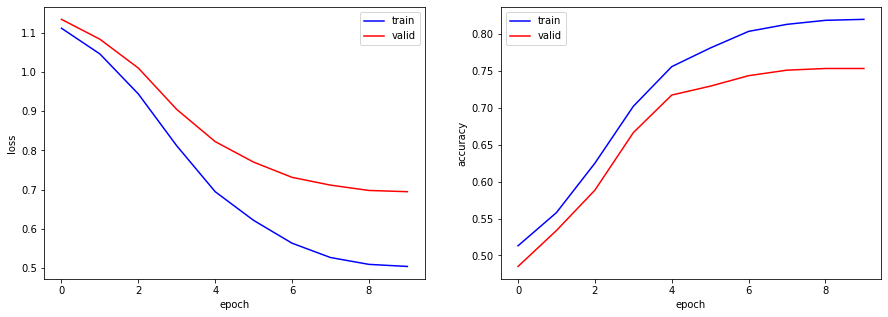

acc_train：0.820
acc_test：0.753


In [16]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．

### 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)）で単語埋め込みemb(x)を初期化し，学習せよ．

### 85. 双方向RNN・多層化
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch09.html)

### 86. 畳み込みニューラルネットワーク (CNN)
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch09.html)

### 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．



### 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．



### 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えば[BERT](https://github.com/google-research/bert)など）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．